## 1. Introduction

In this assignment I have to implement CNN meets Vision Transformer (CMT) on classification of CIFAR-10 dataset.


## 2. Data Setup

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### 2.1 Downloading and importing the data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms, Resize, Compose
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split, Subset
from torch.utils.data.dataset import Dataset
import torch.optim as optim
from torchsummary import summary

import time as tt

/home/pthapa2/.conda/envs/opt/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/pthapa2/.conda/envs/opt/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seed = 40
np.random.seed(seed)
torch.manual_seed(seed)


In [4]:

data_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean = [0.491, 0.482, 0.447], std = [0.247, 0.243, 0.262])
])

In [5]:

from torchvision import datasets, transforms
data_dir = './data'

train = datasets.CIFAR10(root = data_dir, train=True,  transform = data_transforms, download = True)
test  = datasets.CIFAR10(root = data_dir, train=False, download = True, transform = data_transforms)



Files already downloaded and verified
Files already downloaded and verified


 1. Each image is resized into 224x224 size.
 2. Transformed into (H,W,C) -> (C,H,W)

### 2.2 Exploration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


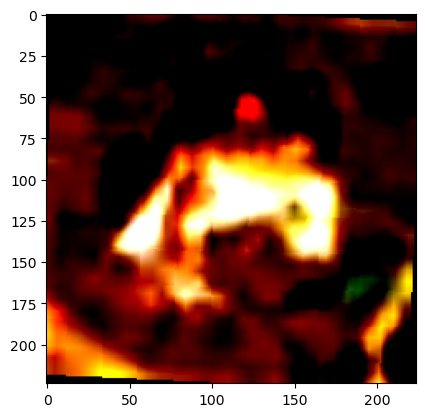

In [6]:
img = train[0][0]
plt.imshow(img.permute(1,2,0))

In [7]:


img.shape, len(train.targets), train.classes, len(train.classes)


(torch.Size([3, 224, 224]),
 50000,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 10)

1. There are a total of 50000 training dataset, each with height and width of 224x224 with 3 channels.
2. Label of 10 classes.

#### 2.2.1 Training dataset

In [8]:
n_class = train.classes
classes = {}

for _, index in train:
    label = n_class[index]
    if label not in classes:
        classes[label] = 0
    classes[label] += 1

classes

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

Each class comprises of 5000 data. Thus, the data is evenly distributed.

In [9]:
train.data.min(), min(train.targets)

(0, 0)

In [10]:
train.data.min(), train.data.max(), min(train.targets), max(train.targets), train.data.mean(), train.targets[0:10]

(0, 255, 0, 9, 120.70756512369792, [6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

1. Minimum value: 0
2. Maximum value: 255
3. Unique classes: 10

#### 2.2.2 Testing dataset

In [11]:
testX = torch.Tensor(test.data)
testY = torch.Tensor(test.targets)

torch.unique(testY, return_counts = True)

(tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

Each class comprises of 1000 data. Thus, the data is evenly distributed.

In [12]:
testX.min(), testX.max(), testY.min(), testY.max(), testX.mean(), testY[0:10]

(tensor(0.),
 tensor(255.),
 tensor(0.),
 tensor(9.),
 tensor(121.5292),
 tensor([3., 8., 8., 0., 6., 6., 1., 6., 3., 1.]))

Training dataset Min value: 0 \
Training dataset Max value: 255 \
Training label Min value: 0 \
Training label Max value: 9


### 2.3 Formatting

### 2.4 Seeded split

In [13]:
generator = torch.Generator()
generator.manual_seed(42)
torch.cuda.manual_seed(42)

train_size = int(0.85 * len(train))
val_size = len(train) - train_size
train_dataset, val_dataset = random_split(train, [train_size, val_size])

#test_dataset = TensorDataset(testX/255, testY)


In [14]:
len(train_dataset), len(val_dataset), len(test)

(42500, 7500, 10000)

### Sampling dataset to train on small number of data

In [15]:
def subset_dataloader(size, dataset):
    indices = range(size)
    s_dataset = Subset(dataset, indices)
    s_loader = DataLoader(s_dataset, batch_size = 16, shuffle = True)
    return s_loader

In [16]:
s_train_loader = subset_dataloader(size = 1000, dataset = train_dataset)
s_val_loader   = subset_dataloader(size = 500, dataset = val_dataset)
s_test_loader  = subset_dataloader(size = 500, dataset = test)



In [17]:
len(s_train_loader), len(s_test_loader), len(s_val_loader)

(63, 32, 32)

No. of Training Dataset: 42500 \
No. of validation Dataset: 7500\
No. of Testing Dataset: 10000

In [18]:
train_dataset

### 2.5 Dataloader function

In [19]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=True)


In [20]:
# comverting the output classes into one hot encoding
def one_hot_encoding(x,y):
    y_one_hot = np.zeros((len(x), 10))
    for i, class_label in enumerate(y):
        y_one_hot[i, class_label] = 1

    return y_one_hot


In [21]:
for i, (images, labels) in enumerate(train_loader):
    print((images.shape))
    break

torch.Size([32, 3, 224, 224])


Each batch consists of 32 images with the size (3,224,224).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


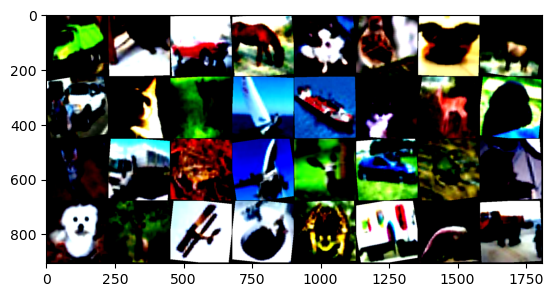

In [22]:
data_iter = iter(train_loader)
images, label = next(data_iter)



grid_img = torchvision.utils.make_grid(images, nrow = 8)
plt.imshow(grid_img.permute(1,2,0))

#plt.imshow(next(data_iter)[0][0])
#images, label = data_iter.next()

## CNN meets Vision Transformer (CMT) Model

### CMT Stem

In [23]:
# CMT Stem class

class CMTStem(nn.Module):
    """
    First pass through 3x3 conv with the stride 2 to reduce the image,
    then the image is passed through 3x3 conv applying GELU with BN twice.

    Input: x-> (b,3,H,W)

    Output : -> ()

    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1, bias = False)
        self.gelu1 = nn.GELU()
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.gelu2 = nn.GELU()
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.gelu3 = nn.GELU()
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.bn1(self.gelu1(self.conv1(x)))
        x = self.bn2(self.gelu2(self.conv2(x)))
        x = self.gelu3(self.conv3(x))
        out = self.bn3(x)
        return out






In [24]:
x = torch.randn(64,3,224,224)
model = CMTStem(3,32)
out = model(x)
print(out.shape)

torch.Size([64, 32, 112, 112])


### Convolution Block

In [25]:
# 2x2 Convolution block with stride = 2

class ConvBlock2x2(nn.Module):

    def __init__(self, in_channels, out_channels, stride = 2 ):
        super(ConvBlock2x2, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 2, stride = stride, padding = 0, bias = True)

    def forward(self, x):
        out = self.conv(x)
        return out


### Depthwise Convolution

In [26]:
# Depthwise Convolution
"""
The depthwise convolution applies the convolution along only a spatial dimension, while a normal
convolution applies the convolution along all spatial dimension at each step.
"""

class DepthwiseConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super(DepthwiseConv, self).__init__()

        self.depthwiseconv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, groups = in_channels, bias = True)

    def forward(self, x):
        out = self.depthwiseconv(x)
        return out


In [27]:
x = torch.randn(64,32,224,224)
dpc = DepthwiseConv(32,32)
out = dpc(x)
print(out.shape)

torch.Size([64, 32, 224, 224])


### Local Perception Unit

![image.png](attachment:image.png)

In [28]:
# Local Perception Unit
"""
This block is inside CMT Block. Vision transformer ignores the local relatoin and the structure
formation inside each patch. During data aumentation, poistional encoding damages the invariance
because it adds unique positional encoding to each patch. Thus, LPU is added to extract local information.

"""
class LPU(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LPU, self).__init__()
        self.dwconv =  DepthwiseConv(in_channels, out_channels)

    def forward(self, x):
        out = self.dwconv(x) + x
        return out

In [29]:
x = torch.randn(64,32,224,224)
lpu = LPU(32,32)
out = lpu(x)
print(out.shape)

torch.Size([64, 32, 224, 224])


### Lightweight Multihead Self Attention

![Lightweight-Multi-Head-Self-Attention-MHSA-architecture.png](attachment:Lightweight-Multi-Head-Self-Attention-MHSA-architecture.png)

In [30]:
# Lightweight Multi-head Self Attention
"""
Inputs:
        Q: [N, C, H, W]
        K: [N, C, H / stride, W / stride]
        V: [N, C, H / stride, W / stride]


"""
class LMHSA(nn.Module):
    def __init__(self, input_size, channels, d_k, d_v, stride, heads, dropout):
        super(LMHSA, self).__init__()
        self.depthwiseconv_k = DepthwiseConv(channels, channels, stride = stride) # divided by stride
        self.depthwiseconv_v = DepthwiseConv(channels, channels, stride = stride) # divided by stride

        self.linear_q = nn.Linear(channels, heads * d_k) # # transformed channel into heads * d_k,
        #done to generate the query vectors per head for self-attention mechanism.
        self.linear_k = nn.Linear(channels, heads * d_k)
        self.linear_v = nn.Linear(channels, heads * d_v)
        self.linear_o = nn.Linear(heads * d_k, channels) # linear layer tp transform the concatented attetion
        # heads outputs back into the original channel dimension

        self.channels = channels
        self.d_k = d_k
        self.d_v = d_v
        #print(d_v)
        self.stride = stride
        self.heads = heads
        self.dropout = dropout
        self.scale = 1/(d_k ** 0.5)

        self.num_patches = (self.d_k // self.stride) ** 2
        self.B = nn.Parameter(torch.Tensor(1, self.heads, input_size ** 2, (input_size // stride) ** 2), requires_grad = True)

    def forward(self, x):
        #print(x.shape)
        b, c, h, w = x.shape



        # Get query
        q = x.view(b, c, h*w) # This flattens the spatial dimensions (h,w) into a singe dimension,
        # each location as seperate entity, but maintaining batch and channel seperation.
        #print(q.shape)
        q = q.permute(0,2,1) # Rearrangement is done because it aligns the tensor so that each spatial location are
        # lined up as seperate features in the last dimension, which is typical format for linear transformation
        # as features are along the last dimension.
       # print(q.shape)
        q = self.linear_q(q) # transformed channel into heads * d_k, done to generate the query vectors
       # print(q.shape) #per head for self-attention mechanism.
#         print(self.d_k)
        q = q.view(b, h*w, self.heads, self.d_k).permute(0,2,1,3) # heads seperates different sets of query vectors for
        # parallel attention
       # print(q.shape)

# Get key
        k = self.depthwiseconv_k(x)
        k = k.view(b,c, -1).permute(0,2,1).contiguous()
        k = self.linear_k(k)
        k = k.view(b, -1, self.heads, self.d_k).permute(0,2,1,3)

        # Get value

        v = self.depthwiseconv_v(x)
        v = self.linear_v(v.view(b,c, -1).permute(0,2,1))
        v = v.view(b, -1, self.heads, self.d_v).permute(0,2,1,3)

       # Attention
        attn = torch.einsum('... i d, ... j d -> ... i j', q, k) * self.scale

        #takes q and k to compute similarity between each query and key vector.
        # ellipsis(...) allows for arbitrary number of preceding dimensions, which is batch size and heads.
        # i, j is the different pixels in an image
        # Scaling helps prevent the dot product values from becoming too large.
        # The result is the attention score which determines how much each element of the sequence should attend to every other element,

        #attn = attn + self.B
        attn = torch.softmax(attn, dim= -1) # [b, heads, h*w, h*w]

        out = torch.matmul(attn, v).permute(0,2,1,3)
        out = out.contiguous().view(b, h * w, self.heads * self.d_v)
        out = self.linear_o(out).view(b, self.channels, h, w)
        out = out + x
       # print(out.shape)
        return out



In [31]:
x = torch.randn(32, 32, 56, 56)
outs = LMHSA(input_size = 56, channels = 32, d_k = 32, d_v = 32, stride = 8, heads =2, dropout = 0.2)
out = outs(x)
out.shape

torch.Size([32, 32, 56, 56])

In [32]:
x = torch.rand(1,3,224,224).to(device)
b, c, h, w = x.shape
heads = 4
d_k = 32

### Inverted Residual Feed forward network

![image.png](attachment:image.png)

In [33]:
class IRFFN(nn.Module):

    def __init__(self,in_channels, R):
        super(IRFFN, self).__init__()
        expansion_channels = int(in_channels * R) # R-> expansion ratio


        self.conv1 = nn.Sequential(
                     nn.Conv2d(in_channels, expansion_channels, kernel_size = 1), # 3xpansion layer
                     nn.GELU(),
                     nn.BatchNorm2d(expansion_channels),

                    )
        self.dwconv =  DepthwiseConv(expansion_channels, expansion_channels)
        self.gelu   = nn.GELU()
        self.bn     = nn.BatchNorm2d(expansion_channels)



        self.conv2 = nn.Sequential(
                     nn.Conv2d(expansion_channels, in_channels, kernel_size = 1), # 3xpansion layer
                     nn.BatchNorm2d(in_channels)

                    )

    def forward(self, x):
        x = self.conv1(x)
        x = self.dwconv(x) + x
        x = self.bn(self.gelu(x))
        out = self.conv2(x)
        #out = self.conv2((self.dwconv(self.conv1(x))) + self.conv1(x))
        return out



In [34]:
irffn = IRFFN(in_channels = 3, R = 2).to(device)
irffn(x).shape

torch.Size([1, 3, 224, 224])

### CMT Block

![image.png](attachment:image.png)

In [35]:
class CMTBlock(nn.Module):
    def __init__(self, img_size, in_channels, d_k, d_v, stride, head, R):
        super(CMTBlock, self).__init__()
        self.lpu   = LPU(in_channels, in_channels) # both the channels are same. To extract local information
        self.norm1 = nn.LayerNorm([in_channels, img_size, img_size])
        self.lmhsa = LMHSA(img_size, in_channels, d_k, d_v, stride, head, 0)
        self.norm2 = nn.LayerNorm([in_channels, img_size, img_size])
        self.irffn = IRFFN(in_channels, R)

    def forward(self, x):
        lpu_out   = self.lpu(x)
        norm1_out = self.norm1(lpu_out)

        lmhsa_out = self.lmhsa(norm1_out) + lpu_out
        norm2_out = self.norm2(lmhsa_out)

        irffn_out = self.irffn(norm2_out) + lmhsa_out
        return irffn_out



In [36]:
x = torch.randn(1,46,56,56)
cmt = CMTBlock(img_size = 56, in_channels = 46, d_k = 46, d_v = 46, stride = 8, head = 2, R = 3.6)
cmt(x).shape

torch.Size([1, 46, 56, 56])

### Patch Embedding layer

In [37]:
class Patch_embedding(nn.Module):
    """
    To produce the hierarchical representation, a patch embedding layer consisting of a convolution
    and a layer normalization (LN) [1]is applied before each stage to reduce the size of intermediate
    feature (2x downsampling of resolution), and project it to a larger dimension (2x enlargement
    of dimension).
    """

    def __init__(self, in_channels, out_channels = None):
        super(Patch_embedding, self).__init__()
        if out_channels is None:
            out_channels = in_channels
        self.conv = ConvBlock2x2(in_channels, out_channels, stride = 2)


    def forward(self, x):
        x = self.conv(x)
        _, c, h, w = x.size()

        result = torch.nn.functional.layer_norm(x, (c, h, w))
        return result


In [38]:
x = torch.rand(64,3,32,32)
b, c, h, w = x.shape

pe = Patch_embedding(3, 32)
m = pe(x)
m.shape

torch.Size([64, 32, 16, 16])

## CNN Meets Vision Transformer

![image.png](attachment:image.png)

In [39]:
class CMT(nn.Module):
    def __init__(self, img_size = 224,
                 in_channels = 3,
                 stem_channels = 16,
                 patch_channels = [46, 92, 184, 368],
                 cmt_channels = [46, 92, 184, 368],
                 total_blocks = [2,2,10,2],
                 R = 3.6
                 ):
        super(CMT, self).__init__()
        img_sizes = [img_size//4, img_size//8, img_size//16, img_size//32]

        #Stem Layer : [224, 224] -> [112,112]
        self.stem = CMTStem(in_channels, stem_channels)

        # Patch Embedding :[112,112] -> [56, 56]
        self.patch_emb1 = Patch_embedding(stem_channels, patch_channels[0])
        self.patch_emb2 = Patch_embedding(patch_channels[0], patch_channels[1])
        self.patch_emb3 = Patch_embedding(patch_channels[1], patch_channels[2])
        self.patch_emb4 = Patch_embedding(patch_channels[2], patch_channels[3])

        #stages layer
        stage1 = []
        for _ in range(total_blocks[0]):
            cmt_layer = CMTBlock(img_size = img_sizes[0],
                                 in_channels = patch_channels[0],
                                 d_k = cmt_channels[0],
                                 d_v = cmt_channels[0],
                                 stride = 8, # higher stride leads to lower computation cost, as it reduces the spatial dimension
                                 head = 1,
                                 R = R)
            stage1.append(cmt_layer)
        self.stage1 = nn.Sequential(*stage1)

        stage2 = []
        for _ in range(total_blocks[1]):
            cmt_layer = CMTBlock(img_size = img_sizes[1],
                                 in_channels = patch_channels[1],
                                 d_k = cmt_channels[1]//2, #why??
                                 d_v = cmt_channels[1]//2,
                                 stride = 4, # strides decreasing because as the image size decreases, it takes less resources to focus on the detailed features.
                                 head = 2,
                                 R = R)
            stage2.append(cmt_layer)
        self.stage2 = nn.Sequential(*stage2)

        stage3 = []
        for _ in range(total_blocks[2]):
            cmt_layer = CMTBlock(img_size = img_sizes[2],
                                 in_channels = patch_channels[2],
                                 d_k = cmt_channels[2]//4,
                                 d_v = cmt_channels[2]//4,
                                 stride = 2, # strides decreasing because as the image size decreases, it takes less resources to focus on the detailed features.
                                 head = 4,
                                 R = R)
            stage3.append(cmt_layer)
        self.stage3 = nn.Sequential(*stage3)

        stage4 = []
        for _ in range(total_blocks[3]):
            cmt_layer = CMTBlock(img_size = img_sizes[3],
                                 in_channels = patch_channels[3],
                                 d_k = cmt_channels[3]//8,
                                 d_v = cmt_channels[3]//8,
                                 stride = 1, # strides decreasing because as the image size decreases, it takes less resources to focus on the detailed features.
                                 head = 8,
                                 R = R)
            stage4.append(cmt_layer)
        self.stage4 = nn.Sequential(*stage4)

        # Global average pooling
        self.gap = nn.AdaptiveAvgPool2d(1)  # size of 1x1

        # fully_connected layer
        self.fc = nn.Sequential(
                    nn.Linear(cmt_channels[3], 1280),
                    nn.ReLU(inplace = True)
                    )

        #classifier
        self.classifier = nn.Linear(1280,10) # there are 10 output classes


    def forward(self, x):
        x = self.stem(x)


        x = self.stage1(self.patch_emb1(x))
        x = self.stage2(self.patch_emb2(x))
        x = self.stage3(self.patch_emb3(x))
        x = self.stage4(self.patch_emb4(x))

        x = self.gap(x)
       # print(x.shape)
        x = torch.flatten(x,1)
       # print(x.shape)
        x = self.fc(x)

        out = self.classifier(x)
        return out



In [40]:
x = torch.randn(3, 3, 224, 224).to(device)
model = CMT().to(device)
out = model(x)
out.shape

torch.Size([3, 10])

In [41]:
summary(model, input_size =(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
              GELU-2         [-1, 16, 112, 112]               0
       BatchNorm2d-3         [-1, 16, 112, 112]              32
            Conv2d-4         [-1, 16, 112, 112]           2,304
              GELU-5         [-1, 16, 112, 112]               0
       BatchNorm2d-6         [-1, 16, 112, 112]              32
            Conv2d-7         [-1, 16, 112, 112]           2,304
              GELU-8         [-1, 16, 112, 112]               0
       BatchNorm2d-9         [-1, 16, 112, 112]              32
          CMTStem-10         [-1, 16, 112, 112]               0
           Conv2d-11           [-1, 46, 56, 56]           2,990
     ConvBlock2x2-12           [-1, 46, 56, 56]               0
  Patch_embedding-13           [-1, 46, 56, 56]               0
           Conv2d-14           [-1, 46,

In [42]:
def accuracy_1hotY(pred, label):
    return (pred.argmax(1) == label.argmax(1)).type(torch.float).mean().item()

###  Training function

In [43]:
def train_func(dataloader, model, loss_fn, optimizer, metric, metric_name='batch accuracy'):
    num_batches = len(dataloader)
    loss_t = 0

    loss_T = 0
    accuracy_T = 0
    model.train()
    for batch, (X, Y) in enumerate(dataloader):

        X = X.float().to(device)
        Y = F.one_hot(Y, num_classes = 10)
        Y = Y.float().to(device)

        Yhat = model(X)

        loss = loss_fn(Yhat, Y)

        loss_t   += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = metric(Yhat, Y)
        accuracy_T += accuracy


        loss_T += loss_t/(batch+1)

        #print(loss_T)
        print(f"batch: {batch+1:5d}/{num_batches} ",
             f"Avg loss: {loss_t/(batch+1):10f}",
            f"Accuracy: {accuracy : 5f}",
            end = '')

    avg_loss = loss_T/ num_batches
    avg_accuracy = accuracy_T / num_batches

    return avg_loss, avg_accuracy

In [44]:
def test_func(dataloader, model, loss_fn, metric, metric_name='accuracy'):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, metric_T  = 0, 0


    model.eval()
    with torch.no_grad():
        for X, Y in dataloader:
            X = X.float().to(device)
            Y = F.one_hot(Y, num_classes = 10)
            Y = Y.float().to(device)
            Yhat = model(X)
            test_loss += loss_fn(Yhat, Y).item()
            metric_T  += metric(Yhat, Y)* len(Y)

    test_loss /= num_batches
    metric_T  /= size
    print(f"loss: {test_loss:7f}, {metric_name}: { metric_T:5f}")
    return test_loss, metric_T

In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
len(train_loader)

1329

In [47]:
import time as tt
from tqdm import tqdm

train_losses, train_accuracies = [], []
val_losses, val_accuracies     = [], []

loss_fn   = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
accuracy  = accuracy_1hotY
epocs = 30

best_accuracy = 0
best_model_path = 'best_model.pth'

for t in range(epocs):
    print("\nEpoch", t+1)
    t0 = tt.time()
    train_loss, train_accuracy = train_func(train_loader, model, loss_fn, optimizer, accuracy)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    print('\nEpoch training time:', tt.time()-t0)
    print('Validation:')
    val_loss, val_accuracy = test_func(valid_loader, model, loss_fn, accuracy)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Saved new best model with accuracy: {best_accuracy}")
print('\nTesting:')
test_func(test_loader, model, loss_fn, accuracy)
print("Done!")



Epoch 1
batch:     1/1329  Avg loss:   2.308939 Accuracy:  0.125000batch:     2/1329  Avg loss:   2.312719 Accuracy:  0.062500batch:     3/1329  Avg loss:   2.305512 Accuracy:  0.093750batch:     4/1329  Avg loss:   2.314360 Accuracy:  0.156250batch:     5/1329  Avg loss:   2.293941 Accuracy:  0.218750batch:     6/1329  Avg loss:   2.286649 Accuracy:  0.125000batch:     7/1329  Avg loss:   2.266302 Accuracy:  0.218750batch:     8/1329  Avg loss:   2.267110 Accuracy:  0.218750batch:     9/1329  Avg loss:   2.252862 Accuracy:  0.218750batch:    10/1329  Avg loss:   2.235251 Accuracy:  0.281250batch:    11/1329  Avg loss:   2.231405 Accuracy:  0.187500batch:    12/1329  Avg loss:   2.228183 Accuracy:  0.125000batch:    13/1329  Avg loss:   2.203459 Accuracy:  0.218750batch:    14/1329  Avg loss:   2.194338 Accuracy:  0.281250batch:    15/1329  Avg loss:   2.186939 Accuracy:  0.281250batch:    16/1329  Avg loss:   2.179049 Accuracy:  0.281250batch:    17/1329  Avg loss:   2.172081 Accurac

In [48]:
import matplotlib.pyplot as plt

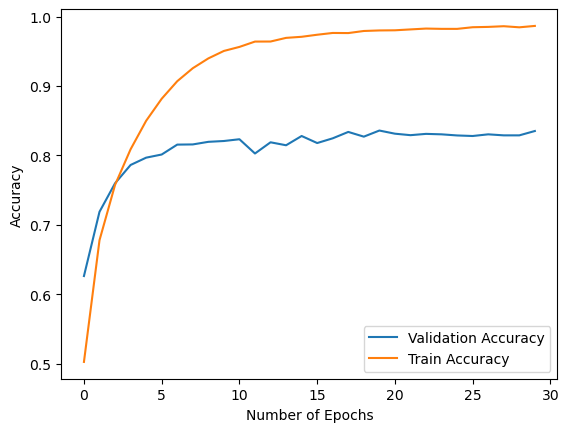

In [49]:
plt.plot(range(len(val_accuracies)), val_accuracies, label = 'Validation Accuracy')
plt.plot(range(len(train_accuracies)), train_accuracies, label = 'Train Accuracy')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.show()

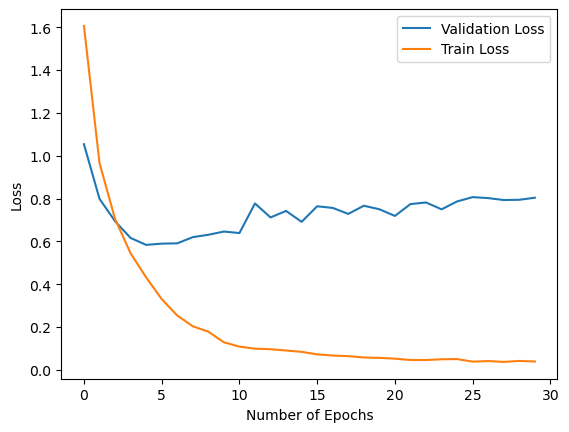

In [50]:

plt.plot(range(len(val_losses)), val_losses, label = 'Validation Loss')
plt.plot(range(len(train_losses)), train_losses, label = 'Train Loss')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.show()

In [51]:
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [52]:
test_func(test_loader, model, loss_fn, accuracy)

loss: 0.770429, accuracy: 0.825100


(0.770428835155484, 0.8251)